# Identification of potential contaminants and assessment of consistency with mock community

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

We used R package _decontam_<cite data-cite="2542765/Q3A9DRWE"></cite> to identify contaminant DNA sequences. For the 16S-AS dataset, _decontam_ used the DNA concentration of sputum samples to identify contaminant amplicon sequence variants (ASVs) whose frequency varied inversely with total DNA concentration (frequency-based identification). For the WMS dataset, the frequency-based identification was complemented with presence of contaminants in background controls (prevalence-based identification) and in a mock community (20 strain even mix genomic material, ATCC <html>&reg;</html> MSA-1002<html>&trade;</html>).


In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-14


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(stringr)
library(gplots)
library(tidyverse)
library(hrbrthemes)
library("RColorBrewer")
library(phyloseq)
library(decontam)
library(dendsort)
library(vegan)
hrbrthemes::import_roboto_condensed()
library(grid)
library(gridExtra)
library("scales")
library(pheatmap)
library(ggplot2)

**Create additional directories**

## 1. Import files

### 1.1 Summaries of Pre/processing of sequencing data

**16S-rRNA gene amplicon sequencing (16S-AS)**

In [5]:
%%R
asv16s_qiime2_summary_file <- './data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run123.tsv'
asv16s_qiime2_summary = read.csv(asv16s_qiime2_summary_file, sep='\t', header=TRUE, row.names=1)
head(asv16s_qiime2_summary)

       input filtered denoised non.chimeric perc_kept
A00030 69471    35777    33346        23903  34.40716
A00034 46103    25102    24765        19104  41.43765
A00036 59728    34850    34422        26914  45.06094
A00038 53641    29543    28367        17434  32.50126
A00053   440      121       49           49  11.13636
A00056 35483    18274    17893        15719  44.30009


**Whole-metagenome shotgun (WMS) sequencing**

In [6]:
%%R
wms_metsnk_preqc_summary_file <- './data/interim/MetaSnk/wms_cases/preQC/summary_stats/wms_cases_preqc_samples_summary.tsv'
wms_metsnk_preqc_summary <- read.csv(wms_metsnk_preqc_summary_file, sep='\t', header=TRUE, row.names=1)
head(wms_metsnk_preqc_summary, n=2)

       total_reads trim_adapters_disc_reads filter_human_disc_reads
M00001       71814                     9522                   12828
M00002    42527990                  1190726                32207562
       dedupe_disc_reads trim_3end_disc_reads total_disc_reads total_kept_reads
M00001                 4                    6            22360            49454
M00002           1582038                  404         34980730          7547260
       trim_adapters_pct_disc filter_human_pct_disc dedupe_pct_disc
M00001              13.424153              18.25201     0.004727811
M00002               2.797835              75.75015     3.719520332
       trim_3end_pct_disc total_pct_disc total_pct_kept
M00001       0.0071164415       31.68801       68.31199
M00002       0.0009453841       82.26846       17.73154


### 1.2 Taxonomic profiles

**16S-AS taxonomic profiles**

In [7]:
%%R
# Loading the feature table
# -------------------------
asv16s_qiime2_feature_table_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filtered_table.tsv"
asv16s_qiime2_feature_table <- read.table(asv16s_qiime2_feature_table_file, header=TRUE, sep='\t', 
                                          stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                          comment.char="", skip=1)
asv16s_qiime2_feature_table[0:3,0:3]

# Loading the taxonomy table
# --------------------------
#' Convert taxonomy table produced by QIIME2 to a 7-ranks data frame
#'
#' @param qiime2_taxonomy A data frame with columns c('Taxon', 'Confidence')
#' @return The taxonomy table as dataframe with seven columns, the seven taxonomic ranks.
qiime2taxonomy_to_df <- function(qiime2_taxonomy){
    features_ids <- rownames(qiime2_taxonomy)
    taxon_ranks_n = 7
    taxon_rank_names = c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
    taxonomies = sapply(qiime2_taxonomy$Taxon, 
                        function(x,nranks){
                            taxonomy_vector = strsplit(x,'; ')[[1]]
                            na_vector = rep(NA,nranks-length(taxonomy_vector))
                            c(taxonomy_vector,na_vector)}, 
                        taxon_ranks_n)
    taxonomies = data.frame(matrix(taxonomies, 
                                   nrow=length(features_ids), 
                                   ncol=taxon_ranks_n, byrow=TRUE), 
                            row.names=features_ids, 
                            stringsAsFactors=FALSE)
    colnames(taxonomies) <- taxon_rank_names
    return(taxonomies)
}

# Load taxonomies
asv16s_taxonomy_table_file <- './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported/taxonomy.tsv'
asv16s_taxonomy_table <- read.table(asv16s_taxonomy_table_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
asv16s_taxonomy_table <- qiime2taxonomy_to_df(asv16s_taxonomy_table)
print(dim(asv16s_taxonomy_table))
print(asv16s_taxonomy_table[0:3,0:3])

# Create phyloseq object
# ----------------------
# Re-format taxonomy table for phyloseq
# Replace non-assigned taxonomy ranks(e.g p__) with NA
is_undefined_rank <- t(unlist(apply(asv16s_taxonomy_table, 1, 
                                    function(x){x %in% c("k__","p__","c__","o__","f__","g__","s__")})))
asv16s_taxonomy_table_ps <- asv16s_taxonomy_table
asv16s_taxonomy_table_ps[ is_undefined_rank ] <- NA

# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table, 
                                              taxa_are_rows=TRUE), 
                                    tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_ps)
# remove ASV with abundance zero
asv16s_feature_table_ps = filter_taxa(asv16s_feature_table_ps, function(x){sum(x) > 0}, TRUE)
print(asv16s_feature_table_ps)

[1] 28284     7
                                     Kingdom           Phylum          Class
0000134bb4f9a56941dd1d0206a600d8 k__Bacteria p__Bacteroidetes c__Bacteroidia
00032a9354651fef5c866ec3f9cdca0d k__Bacteria p__Bacteroidetes c__Bacteroidia
000374910b98b14cc5724af75f294b87 k__Bacteria p__Bacteroidetes c__Bacteroidia
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28282 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28282 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28282 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28282 taxa by 7 taxonomic ranks ]


Summarizing stats of number of ASVs per samples:

In [13]:
%%R
summary(colSums(asv16s_qiime2_feature_table>0))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0   111.0   171.0   199.9   252.0   786.0 


**Taxonomic profiles from Whole-Metagenome shotgun (WMS) sequencing**

In [8]:
%%R
# Import the species-level WMS taxonomic profiles
metaphlan_profiles_file <- "./data/interim/MetaSnk/wms_cases/PhlAnProf/metaphlan/profiles_merged/wms_cases_abundances_table.txt"
metaphlan_profiles <- read.table(metaphlan_profiles_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
dim(metaphlan_profiles)

[1] 1094  129


In [9]:
%%R
# Species abundances
# ---------------------
species_all <- grep("^k__[[:graph:]]*\\|s__[^\\|]*$", rownames(metaphlan_profiles), value=TRUE)

# Relative abundances (%)
metaphlan_all_spp_abund_table <- metaphlan_profiles[species_all,]
metaphlan_all_spp_abund_table <- metaphlan_all_spp_abund_table[rowSums(metaphlan_all_spp_abund_table)>0,]
print(dim(metaphlan_all_spp_abund_table))

# Relative counts
metaphlan_all_spp_counts_table <- t(apply(metaphlan_all_spp_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_metsnk_preqc_summary[colnames(metaphlan_all_spp_abund_table),
                                                                     "total_kept_reads"]))
print(dim(metaphlan_all_spp_counts_table))

# Taxonomy assignment
metaphlan_all_spp_taxonomy <- as.data.frame(do.call(rbind,strsplit(rownames(metaphlan_all_spp_counts_table),"\\|")))
colnames(metaphlan_all_spp_taxonomy) <- c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
rownames(metaphlan_all_spp_taxonomy) <- metaphlan_all_spp_taxonomy$Species

rownames(metaphlan_all_spp_counts_table) <- metaphlan_all_spp_taxonomy$Species
rownames(metaphlan_all_spp_abund_table) <- metaphlan_all_spp_taxonomy$Species

cat("\nNr of species:")
cat(dim(metaphlan_all_spp_taxonomy)[1])

[1] 273 129
[1] 273 129

Nr of species:273

### 1.3 Sample/Specimen/Host metadata

**DNA concentration**

In [10]:
%%R
sputum_dna_conc_file <- './data/raw/metadata/samples_dna_conc.tsv'
sputum_dna_conc <- read.table(sputum_dna_conc_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                              row.names=1, na.strings=c('unknown',''))
head(sputum_dna_conc, n=3)

       qubit_dna_conc_ng_ul
S00181                50.00
S00375                45.10
S00508                 3.02


**Tables with mapping IDs**

In [11]:
%%R
asv16s_mapping_ids_file <- "./data/raw/tz_spt_cases/sample_ids_mapping.txt"
wms_mapping_ids_file <- "data/raw/wms/wms_cases/sample_ids_mapping.txt"

asv16s_mapping_ids <- read.table(asv16s_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)
wms_mapping_ids <- read.table(wms_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)

print(head(asv16s_mapping_ids, n=3))
print(head(wms_mapping_ids, n=3))

       SpecimenID SubjectID seq_run
A00030     S00394    H00388    run1
A00034     S00426    H00421    run1
A00036     S00173    H00173    run1
       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3          


### 1.4 Mock community

In [12]:
%%R
atcc_mock_community_file <- './data/raw/metadata/atcc_msa_1002_mock_community.tsv'
atcc_mock_community <- read.table(atcc_mock_community_file, header=FALSE, sep='\t', stringsAsFactors=FALSE, 
                                  col.names=c('species','atcc'))
head(atcc_mock_community, n=3)

                    species         atcc
1   Acinetobacter baumannii (ATCC 17978)
2 Actinomyces odontolyticus (ATCC 17982)
3           Bacillus cereus (ATCC 10987)


## 2. Identification of background contaminants

### 2.1 16S-AS profiles

In [13]:
%%R
# Find samples with both 16S-AS data and DNA concentration
specimenIDs_with_16S_and_dnaconc <- intersect(asv16s_mapping_ids[sample_names(asv16s_feature_table_ps),
                                                                 'SpecimenID'], rownames(sputum_dna_conc))
specimenIDs_with_16S_and_dnaconc_mapping <- asv16s_mapping_ids[asv16s_mapping_ids$SpecimenID %in% 
                                                               specimenIDs_with_16S_and_dnaconc,]
print(head(specimenIDs_with_16S_and_dnaconc_mapping))

sputum_dna_conc_for_16Ssamples <- sputum_dna_conc[specimenIDs_with_16S_and_dnaconc_mapping$SpecimenID, , drop=F]
rownames(sputum_dna_conc_for_16Ssamples) <- rownames(specimenIDs_with_16S_and_dnaconc_mapping)
sputum_dna_conc_for_16Ssamples['seq_run'] <- specimenIDs_with_16S_and_dnaconc_mapping$seq_run
print(head(sputum_dna_conc_for_16Ssamples))

# Add DNA concentration metadata to phyloseq object
asv16s_feature_table_ps_decontam <- merge_phyloseq(asv16s_feature_table_ps, 
                                                   sample_data(sputum_dna_conc_for_16Ssamples))
print(asv16s_feature_table_ps_decontam)
# Convert to relative abundances
asv16s_feature_table_ra_ps_decontam <- transform_sample_counts(asv16s_feature_table_ps_decontam, 
                                                      function(x){100*x/sum(x)})
# remove ASV with abundance zero
asv16s_feature_table_ra_ps_decontam = filter_taxa(asv16s_feature_table_ra_ps_decontam, 
                                                  function(x){sum(x) > 0}, TRUE)
print(asv16s_feature_table_ra_ps_decontam)

       SpecimenID SubjectID seq_run
A00053     S00298    H00294    run1
A00103     S00076    H00076    run1
A00117     S00265    H00262    run1
A00130     S00169    H00169    run1
A00132     S00217    H00216    run1
A00150     S00287    H00284    run1
       qubit_dna_conc_ng_ul seq_run
A00053                16.30    run1
A00103                 5.18    run1
A00117                43.90    run1
A00130                50.00    run1
A00132                42.10    run1
A00150                19.80    run1
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28282 taxa and 126 samples ]
sample_data() Sample Data:       [ 126 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 28282 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9078 taxa and 126 samples ]
sample_data() Sample Data:       [ 126 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 9078 taxa by 7 taxonomic ranks ]


In [14]:
%%R
asv16s_decontam_stat <- isContaminant(asv16s_feature_table_ra_ps_decontam,
                                      method="frequency", normalize=FALSE,
                                      conc="qubit_dna_conc_ng_ul", 
                                      batch="seq_run")

head(asv16s_decontam_stat[asv16s_decontam_stat$contaminant,])

                                         freq prev      p.freq p.prev
078333cf207589586a7d50def857e211 8.629914e-05    2 0.006309296     NA
0ac164b7b2431296126f32aafc00d5eb 1.833625e-03    2 0.011675510     NA
0e6686b09decd0601c4dc11621140e1e 1.537548e-03    2 0.047711365     NA
13c7c9efdc5bdf4b877b98eb6ca9f041 2.996469e-03    6 0.097976230     NA
1fcde512a618b1e17ece8c484b915bb2 3.435991e-03    2 0.011008002     NA
263dd5422b8dd8d544909cd47a970fe7 7.210758e-02    8 0.033820840     NA
                                           p contaminant
078333cf207589586a7d50def857e211 0.006309296        TRUE
0ac164b7b2431296126f32aafc00d5eb 0.011675510        TRUE
0e6686b09decd0601c4dc11621140e1e 0.047711365        TRUE
13c7c9efdc5bdf4b877b98eb6ca9f041 0.097976230        TRUE
1fcde512a618b1e17ece8c484b915bb2 0.011008002        TRUE
263dd5422b8dd8d544909cd47a970fe7 0.033820840        TRUE


How many ASVs were detected as contaminants?

In [15]:
%%R
table(asv16s_decontam_stat$contaminant)


FALSE  TRUE 
 9035    43 


Lets check how prevalent are these ASVs in the dataset used to evaluate contamination ( including only samples for which we knew their DNA concentration):

In [16]:
%%R
asv16s_decontam_stat[asv16s_decontam_stat$contaminant,'prev']

 [1] 2 2 2 6 2 8 3 2 2 6 7 2 2 6 2 2 2 4 2 2 2 3 2 2 4 2 2 4 3 2 2 2 2 2 2 2 3 2
[39] 3 2 2 2 2


Most of the ASVs were classified as contaminants based on the inverse linear relationship of their abundances with the total DNA concentrations of only two samples. We increased the stringency of the contamination classification by requiring at least four samples.

Lets plot the relative abundance of those ASVs flagged as contaminants by _decontam_ and after keeping only those found in at least four samples:

In [17]:
%%R -w 600 -h 800 -u px
print(par('din'))
asv16s_contaminants_ids <- rownames(asv16s_decontam_stat)[(asv16s_decontam_stat$contaminant)
                                                          & (asv16s_decontam_stat$prev >=4)]
asv16s_contaminants_labels <- paste(asv16s_taxonomy_table[asv16s_contaminants_ids,"Genus"],
                                   asv16s_taxonomy_table[asv16s_contaminants_ids,"Species"], sep="; ")
cat("\nNumbers of contaminant ASVs: ")
cat(length(asv16s_contaminants_ids))

plot_facets_labels <- data.frame(label=asv16s_contaminants_labels,
                                 taxa=factor(asv16s_contaminants_ids))
asv16s_decontam_panel <- plot_frequency(asv16s_feature_table_ra_ps_decontam, 
                                        asv16s_contaminants_ids, conc="qubit_dna_conc_ng_ul", 
                                        normalize=FALSE) + 
                                       xlab("DNA Concentration (ng/ul)") + 
                                       ylab("Relative abundance (%)") + 
                                       geom_text(data=plot_facets_labels, 
                                                 mapping=aes(x=0, y=0.3, label=label), 
                                       hjust=-0.2, vjust=0) + 
                                       theme_bw()
plot(asv16s_decontam_panel)

# # Save the panel
asv16s_decontam_panel_file <- "./reports/figures/16S-AS_decontam_panel.pdf"
ggsave(asv16s_decontam_panel_file, asv16s_decontam_panel, width=8.33, height=11.11, units="in")

# save the list of ASV contaminants with stats
asv16s_contaminants_ids_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/asv16s_contaminants_decontam.tsv"
#writeLines(asv16s_contaminants_ids, file(asv16s_contaminants_ids_file))
asv16s_contaminants_df <- data.frame(featureid=asv16s_contaminants_ids)
asv16s_contaminants_df <- cbind(asv16s_contaminants_df, asv16s_decontam_stat[asv16s_contaminants_ids,])
write.table(asv16s_contaminants_df, asv16s_contaminants_ids_file, 
            sep="\t", row.names=FALSE)


[1]  8.333333 11.111111

Numbers of contaminant ASVs: 8

In [18]:
!head -n3 "./data/interim/QIIME2/tz_spt_cases_fwd/asv16s_contaminants_decontam.tsv"
!wc -l "./data/interim/QIIME2/tz_spt_cases_fwd/asv16s_contaminants_decontam.tsv"

"featureid"	"freq"	"prev"	"p.freq"	"p.prev"	"p"	"contaminant"
"13c7c9efdc5bdf4b877b98eb6ca9f041"	0.00299646907085445	6	0.0979762303643041	NA	0.0979762303643041	TRUE
"263dd5422b8dd8d544909cd47a970fe7"	0.0721075753286487	8	0.0338208396943096	NA	0.0338208396943096	TRUE
9 ./data/interim/QIIME2/tz_spt_cases_fwd/asv16s_contaminants_decontam.tsv


Remove contaminants from feature tables:

In [19]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam
time \
singularity exec \
    --app QIIME2 ./containers/meta16S.sif \
        qiime feature-table filter-features \
        --i-table "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/tree/filtered_table.qza" \
        --m-metadata-file "./data/interim/QIIME2/tz_spt_cases_fwd/asv16s_contaminants_decontam.tsv" \
        --p-exclude-ids True \
        --o-filtered-table "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.qza" \
        --verbose &> "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/filter-features.log"
        
ls ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam

decontam_table_biom
decontam_table.qza
decontam_table.tsv
filter-features.log



real	0m13.586s
user	0m5.534s
sys	0m3.519s


In [20]:
!cat ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/filter-features.log

Saved FeatureTable[Frequency] to: ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.qza


Lets create a QIIME2's visualization file of the FeatureTable after removal of potential contaminant features:

In [21]:
%%bash
mkdir -p ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/decontam
# Summary of the FeatureTable[Frequency]
singularity exec \
    --app QIIME2 ./containers/meta16S.sif \
    qiime feature-table summarize \
        --i-table ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.qza \
        --o-visualization ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/decontam/decontam_table
        
ls ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/decontam

Saved Visualization to: ./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/decontam/decontam_table.qzv
decontam_table.qzv


Lets transform the decontaminated FeatureTable to a biom and tsv tables:

In [22]:
%%bash
singularity exec --app QIIME2 ./containers/meta16S.sif \
    qiime tools export \
        --input-path ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.qza \
        --output-path ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table_biom

biom convert \
-i ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table_biom/feature-table.biom \
-o ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.tsv \
--table-type="OTU table" --to-tsv

ls -lh ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/

Exported ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.qza as BIOMV210DirFmt to directory ./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table_biom
total 38M
drwxr-xr-x 2 ticlla gagneux  512 14. Jul 21:49 decontam_table_biom
-rw-r--r-- 1 ticlla gagneux 1.2M 14. Jul 21:48 decontam_table.qza
-rw-r--r-- 1 ticlla gagneux  38M 14. Jul 21:49 decontam_table.tsv
-rw-r--r-- 1 ticlla gagneux  111 14. Jul 21:48 filter-features.log


### 2.2 WMS profiles

We 

In [23]:
%%R
background_controls_ids <- c("NC1","NC2","NC3")
# Find samples with both WMS-S data and DNA concentration
specimenIDs_with_wms_and_dnaconc <- intersect(wms_mapping_ids[colnames(metaphlan_all_spp_abund_table),
                                                                 'SpecimenID'], rownames(sputum_dna_conc))

specimenIDs_with_wms_and_dnaconc_mapping <- wms_mapping_ids[wms_mapping_ids$SpecimenID %in% 
                                                               specimenIDs_with_wms_and_dnaconc,]
print(head(specimenIDs_with_wms_and_dnaconc_mapping))

sputum_dna_conc_wms_subset <- sputum_dna_conc[specimenIDs_with_wms_and_dnaconc_mapping$SpecimenID, , drop=F]

sputum_dna_conc_wms_subset["isControl"] <- FALSE
sputum_dna_conc_wms_subset[(rownames(sputum_dna_conc_wms_subset) %in% background_controls_ids),
                           "isControl"] <- TRUE
# This value is used for background controls with DNA conc below's qubit quantification limit
qubit_detect_limit_ng_ul <- 0.025
sputum_dna_conc_wms_subset[background_controls_ids,'qubit_dna_conc_ng_ul'] <- qubit_detect_limit_ng_ul

rownames(sputum_dna_conc_wms_subset) <- rownames(specimenIDs_with_wms_and_dnaconc_mapping)
print(head(sputum_dna_conc_wms_subset))


wms_decontam_stat <- isContaminant(t(metaphlan_all_spp_abund_table)[rownames(sputum_dna_conc_wms_subset),],
                                      method="either", threshold=c(0.1,0.5), normalize=FALSE, 
                                   neg=sputum_dna_conc_wms_subset$isControl,
                                   conc=sputum_dna_conc_wms_subset$qubit_dna_conc_ng_ul)
cat("\nSpecies identified as potential contaminants:\n")
print(wms_decontam_stat[wms_decontam_stat$contaminant,])

       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3          
M00007     S00388    H00382
M00011     S00249    H00247
M00012     S00213    H00212
       qubit_dna_conc_ng_ul isControl
M00001               50.000     FALSE
M00002               45.100     FALSE
M00004                0.025      TRUE
M00007               42.500     FALSE
M00011               56.200     FALSE
M00012               10.600     FALSE

Species identified as potential contaminants:
                                    freq prev    p.freq      p.prev  p
s__Rothia_unclassified         0.1181675   14 0.7787161 0.164808399 NA
s__Propionibacterium_acnes     0.1735628    7 0.8592238 0.003884514 NA
s__Granulicatella_unclassified 2.7875983   74 0.9948223 0.409150356 NA
s__Ralstonia_pickettii         0.5630356   43 0.9818871 0.489364829 NA
s__Ralstonia_unclassified      8.6211613   86 0.9928176 0.153490814 NA
                               contaminant
s__Rothia_unclassified

Decontam results indicate that contaminant species were identified by the "prevalence" method that identifies as contaminants species more prevalent in negative controls (threshold=0.5). None of the potential contaminants were identified by decontam's "frequency" method (the frequency/abundance decreases with the input DNA concentration), as shown in the plots below:

[1] 8.333333 6.944444


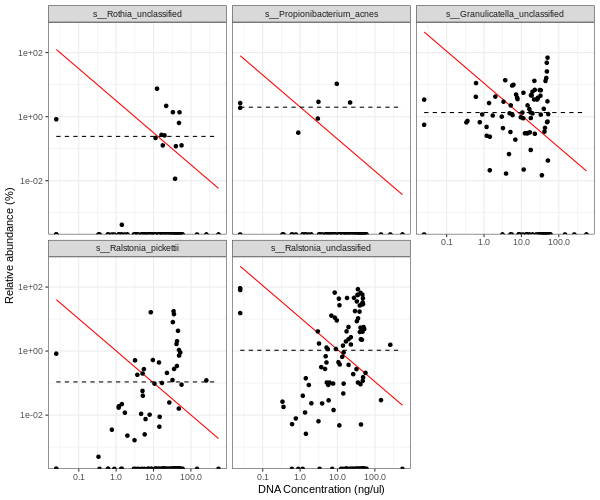

In [24]:
%%R -w 600 -h 500 -u px
print(par('din'))
wms_contaminants_ids <- rownames(wms_decontam_stat[(wms_decontam_stat$contaminant) & 
                                 (wms_decontam_stat$prev >=4),])

wms_decontam_freq_panel <- plot_frequency(t(metaphlan_all_spp_abund_table)[rownames(sputum_dna_conc_wms_subset),], 
                                     taxa=wms_contaminants_ids, 
                                     conc=sputum_dna_conc_wms_subset$qubit_dna_conc_ng_ul, 
                                     #neg=sputum_dna_conc_wms_subset$isControl,
                                     normalize=FALSE) + 
                        xlab("DNA Concentration (ng/ul)") + 
                        ylab("Relative abundance (%)") +
                        theme_bw()
wms_decontam_freq_panel

[1] 13.888889  2.777778


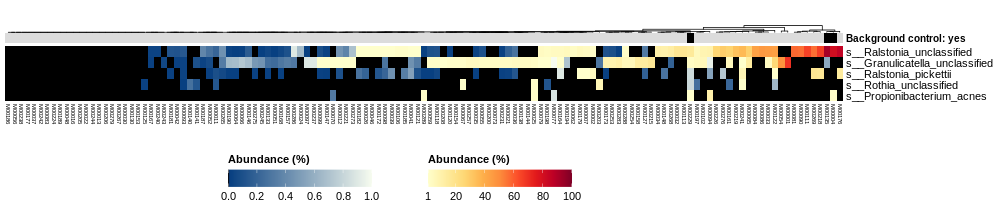

In [25]:
%%R -w 1000 -h 200 -u px
library(pheatmap)
print(par('din'))

# Define colors
color_palette_blues <- colorRampPalette(c("#f7fcf0", "#084081"))
color_palette_reds <- colorRampPalette(brewer.pal(9, "YlOrRd"))
# To color relative abundances with zero values in white
breaks_below1 <- seq(0,1, length.out=100) # below 1% in blue scale
breaks_above1 <- seq(1.05,100, length.out=100) # above 1%, colored from orange to red
color_breaks <- c(-0.1,breaks_below1,breaks_above1)
color_colors <- c("black",rev(color_palette_blues(length(breaks_below1))), 
                  color_palette_reds(length(breaks_above1)-1))
# Annotations for samples
wms_contaminants_heatmap_annotations <- data.frame("Background control: yes" = as.factor(sputum_dna_conc_wms_subset$isControl), 
                                                   check.names = FALSE)
wms_contaminants_heatmap_ann_colors <- list("Background control: yes" = c("TRUE"="black", "FALSE"="#DCDCDC"))
rownames(wms_contaminants_heatmap_annotations) <- rownames(sputum_dna_conc_wms_subset)

# To sort dendrogram
sort_hclust <- function(...) as.hclust(dendsort(as.dendrogram(...)))
wms_contaminants_heatmap_samples_hclust <- sort_hclust(hclust(vegdist(t(metaphlan_all_spp_abund_table)[,wms_contaminants_ids], 
                                                                      method="euclidean")))
# Plot
# Define legends for annotations
create_cont_gglegend <- function(name,values,limits=c(0,1),
                                 breaks=c(-0.1,0,0.2,0.4,0.6,0.8),
                                 colors=c("black","red"),position="bottom"){
    dummy_plot <- ggplot() +
    geom_tile(aes(x='1', y=values, fill=values)) + 
    scale_fill_gradientn(name=name,
                         values=rescale(values, to=c(0,1)),
                         limits=limits,
                         breaks=breaks,
                         colors=colors
                         ) + 
    theme_void() + 
    theme(legend.title=element_text(size=11,face='bold'), 
          legend.text=element_text(size=11))
    if(position=="bottom"){
        dummy_plot <- dummy_plot +
        theme(legend.position=position) +
        guides(fill=guide_colourbar(title.position="top",barwidth=10))

    }
    cowplot::get_legend(dummy_plot)
}

colorbar_blv1 <- create_cont_gglegend(name="Abundance (%)",
                                      values=breaks_below1,
                                      breaks=c(-0.1,0,0.2,0.4,0.6,0.8,1),
                                      limits=c(0,1),
                                      colors=c("black",rev(color_palette_blues(length(breaks_below1))))
                                     )
colorbar_abv0 <- create_cont_gglegend(name="Abundance (%)",
                                      values=seq(1.05,100, length.out=100),
                                      breaks=c(1,20,40,60,80,100),
                                      limits=c(1,100),
                                      colors=color_palette_reds(length(breaks_above1)-1))

wms_contaminants_heatmap <- pheatmap(metaphlan_all_spp_abund_table[wms_contaminants_ids,], 
                                     color=color_colors,
                                     breaks=color_breaks, 
                                     border_color=NA,
                                     show_rownames = TRUE,
                                     cellheight=11,
                                     fontsize_row=11,
                                     fontsize_col=6,
                                     annotation_col=wms_contaminants_heatmap_annotations,
                                     annotation_colors=wms_contaminants_heatmap_ann_colors,
                                     cluster_cols=wms_contaminants_heatmap_samples_hclust,
                                     treeheight_row=0,
                                     treeheight_col=2,
                                     legend=FALSE, 
                                     annotation_legend=FALSE,
                                     scale = 'none',
                                     silent=TRUE
                                    )

heatmap_layout <- rbind(c(1,1,1,1,1),
                        c(NA,2,2,NA,NA))
grid.arrange(grobs=list(wms_contaminants_heatmap[[4]],
                        cbind(colorbar_blv1, colorbar_abv0, size="last")),
             layout_matrix=heatmap_layout, 
             heights=c(0.9,0.25))

There is a group of samples with high relative abundances of potential contaminant species:

In [26]:
%%R -w 1000 -h 200 -u px
print(par('din'))
# Samples with more than 20% abundance of contaminants
wms_samples_highcont <- names(which(colSums(metaphlan_all_spp_abund_table[wms_contaminants_ids,])>=20))
cat("Nr. of samples with high content of potential contaminant species:",length(wms_samples_highcont))

# save the list of WMS contaminants with stats
wms_contaminants_ids_file <- "./data/interim/wms_contaminants_decontam.tsv"
wms_contaminants_df <- data.frame(sp_id=wms_contaminants_ids)
wms_contaminants_df <- cbind(wms_contaminants_df, wms_decontam_stat[wms_contaminants_ids,])
write.table(wms_contaminants_df, wms_contaminants_ids_file, sep="\t", row.names=FALSE)

#save list of contaminated samples
wms_samples_highcont_file <- "./data/interim/wms_contaminated_samples_ids.tsv"
writeLines(wms_samples_highcont, file(wms_samples_highcont_file))


[1] 13.888889  2.777778
Nr. of samples with high content of potential contaminant species: 22

Lets create a visual panel of the results:

In [27]:
%%R -w 700 -h 700
print(par("din"))
# Save plots
heatmap_layout <- rbind(c(1,1,1,1,1),
                        c(2,2,2,2,2),
                        c(3,3,3,3,3),
                        c(4,4,4,4,4),
                        c(NA,5,5,5,NA))

wms_decontam_panel <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                       gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                              wms_decontam_freq_panel,
                                              textGrob("B",just="left", x=unit(0, "npc"), 
                                                       gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                              wms_contaminants_heatmap[[4]],
                                              #Legends
                                              cbind(colorbar_blv1, colorbar_abv0, size="last")
                                             ),
                                   layout_matrix=heatmap_layout,
                                   nrow=5, heights=c(0.05,0.65,0.05,0.17,0.08))

# Saving panel
wms_decontam_panel_file <- "./reports/figures/WMS-S_decontam_panel.pdf"
ggsave(wms_decontam_panel_file, wms_decontam_panel, width=9.722, height=9.722, device=cairo_pdf)


[1] 9.722222 9.722222


In [28]:
!ls reports/figures/

16S-AS_decontam_panel.pdf
16S-AS_norarefied-vs-rarefied-clr-ordinations.pdf
16S-AS_QC-filtering-denoising.svg
16S_Faith-rarefaction-curves.svg
as16s_betadiv_biplot_interactions_permanova.pdf
asv16s_bact_genus_biplots_network.pdf
asv16s_bact_genus_network.pdf
asv16s_biplot_network_interactions.pdf
asv16s_faithpd_ancova_cxrs.pdf
asv16s_faithpd_ancova_lineage.pdf
asv16s_selenomonas_interactions.pdf
mycobacterium_asv_spp_by_afb_grading.pdf
sputum_volume_by_disease_manifestatios.pdf
taxonomic_abundances_panel.pdf
WMS-S_decontam_panel.pdf
WMS-S_MetaSnk-preQC_counts.svg
WMS-S_MetaSnk-preQC_pct.svg
WMS-S_mock_community_panel.pdf


## 3. Assessment of consistency with mock community

In [29]:
%%R
atcc_mock_community

                        species            atcc
1       Acinetobacter baumannii    (ATCC 17978)
2     Actinomyces odontolyticus    (ATCC 17982)
3               Bacillus cereus    (ATCC 10987)
4          Bacteroides vulgatus     (ATCC 8482)
5  Bifidobacterium adolescentis    (ATCC 15703)
6      Clostridium beijerinckii    (ATCC 35702)
7           Cutibacterium acnes    (ATCC 11828)
8       Deinococcus radiodurans  (ATCC BAA­816)
9         Enterococcus faecalis    (ATCC 47077)
10             Escherichia coli   (ATCC 700926)
11          Helicobacter pylori   (ATCC 700392)
12        Lactobacillus gasseri    (ATCC 33323)
13       Neisseria meningitidis  (ATCC BAA­335)
14     Porphyromonas gingivalis    (ATCC 33277)
15       Pseudomonas aeruginosa     (ATCC 9027)
16      Rhodobacter sphaeroides    (ATCC 17029)
17        Staphylococcus aureus (ATCC BAA­1556)
18   Staphylococcus epidermidis    (ATCC 12228)
19     Streptococcus agalactiae  (ATCC BAA­611)
20         Streptococcus mutans   (ATCC 

Notice that *Propionibacterium acnes* was flagged as a contaminant by decontam, however this species is part of the mock community and therefore shouldn't be removed from the taxonomic profile of this particular control sample.

In [30]:
%%R

positive_control_id <- rownames(wms_mapping_ids)[wms_mapping_ids$SpecimenID == "POSITIVE_CONTROL"]
wms_mock_community_sp_ra <- metaphlan_all_spp_abund_table[metaphlan_all_spp_abund_table[,positive_control_id,] >0, 
                                                          positive_control_id, drop=F]
cat("Nr. of species detected in mock community control: ", dim(wms_mock_community_sp_ra)[1], "\n")
print(wms_mock_community_sp_ra)

# Remove species flagged as potential contaminants
wms_contaminants_file <- "./data/interim/wms_contaminants_decontam.tsv"
wms_contaminants <- read.table(wms_contaminants_file, header=TRUE, sep='\t', stringsAsFactors=FALSE)
wms_contaminants <- wms_contaminants[wms_contaminants$sp_id != "s__Propionibacterium_acnes",]
cat("\nContaminant spp. to remove: \n")
print(wms_contaminants$sp_id)

is_contaminant_in_mock_community <- rownames(wms_mock_community_sp_ra) %in% wms_contaminants$sp_id
cat("\nContaminant spp. found in mock community: \n")
print(wms_mock_community_sp_ra[is_contaminant_in_mock_community, , drop=F])
cat("Cumulative abundance covered by contaminants in mock community: ", 
    sum(wms_mock_community_sp_ra[is_contaminant_in_mock_community,]), 
    "\n")

wms_mock_community_sp_ra <- wms_mock_community_sp_ra[!is_contaminant_in_mock_community, , drop=F]
cat("\nNr. of species in mock community control, after contaminant removal: ", 
    dim(wms_mock_community_sp_ra)[1])


Nr. of species detected in mock community control:  25 
                                  M00289
s__Actinomyces_odontolyticus     3.06574
s__Propionibacterium_acnes       2.90308
s__Bifidobacterium_adolescentis  4.51603
s__Bacteroides_vulgatus          8.10755
s__Porphyromonas_gingivalis      5.57912
s__Deinococcus_radiodurans       2.66764
s__Deinococcus_wulumuqiensis     0.00156
s__Bacillus_cereus_thuringiensis 3.22020
s__Staphylococcus_aureus         6.62247
s__Staphylococcus_epidermidis    5.79535
s__Enterococcus_faecalis         6.05268
s__Lactobacillus_gasseri         5.20451
s__Streptococcus_agalactiae      7.12702
s__Streptococcus_mutans          6.57710
s__Clostridium_beijerinckii      6.21458
s__Rhodobacter_sphaeroides       3.32939
s__Ralstonia_pickettii           0.00165
s__Ralstonia_unclassified        0.00644
s__Neisseria_meningitidis        3.52001
s__Helicobacter_pylori           6.42940
s__Escherichia_coli              4.68715
s__Escherichia_unclassified      0.46314
s

How well it overlaps with the expected composition?

In [31]:
%%R
cat("Mock community species, detected by WMS-S: \n")
atcc_mock_detected <- intersect(sub(' ','_',atcc_mock_community$species),
                                sub('s__','',rownames(wms_mock_community_sp_ra)))
print(atcc_mock_detected)

cat("\nMock community species, non detected by WMS: \n")
atcc_mock_not_deceted <- setdiff(sub(' ','_',atcc_mock_community$species),
                                sub('s__','',rownames(wms_mock_community_sp_ra)))
print(atcc_mock_not_deceted)

cat("\nContaminant species in mock community? \n")
wms_mock_contaminants <- setdiff(sub('s__','',rownames(wms_mock_community_sp_ra)), 
                                 sub(' ','_',atcc_mock_community$species))
print(wms_mock_contaminants)

Mock community species, detected by WMS-S: 
 [1] "Acinetobacter_baumannii"      "Actinomyces_odontolyticus"   
 [3] "Bacteroides_vulgatus"         "Bifidobacterium_adolescentis"
 [5] "Clostridium_beijerinckii"     "Deinococcus_radiodurans"     
 [7] "Enterococcus_faecalis"        "Escherichia_coli"            
 [9] "Helicobacter_pylori"          "Lactobacillus_gasseri"       
[11] "Neisseria_meningitidis"       "Porphyromonas_gingivalis"    
[13] "Pseudomonas_aeruginosa"       "Rhodobacter_sphaeroides"     
[15] "Staphylococcus_aureus"        "Staphylococcus_epidermidis"  
[17] "Streptococcus_agalactiae"     "Streptococcus_mutans"        

Mock community species, non detected by WMS: 
[1] "Bacillus_cereus"     "Cutibacterium_acnes"

Contaminant species in mock community? 
[1] "Propionibacterium_acnes"       "Deinococcus_wulumuqiensis"    
[3] "Bacillus_cereus_thuringiensis" "Escherichia_unclassified"     
[5] "Pseudomonas_unclassified"     


There are two species in the MetaPhlAn2 profile, _Propionibacterium acnes_ and _Bacillus cereus thuringiensis_ that are part of the mock community but with different names (_Cutibacterium acnes_ and _Bacillus cereus_). Thus, all species in the mock community were detected in our WMS data, which leaves three species as potential contaminants:
- Pseudomonas_unclassified
- Deinococcus_wulumuqiensis
- Escherichia_unclassified

With the exception of *Deinococcus wulumuqiensis*, the other two "spp" aggregate reads that were only classified until the genus levels, genera Pseudomonas and Escherichia. Those reads might correspond to the species *Pseudomonas aeruginosa* and *Escherichia coli*, which are part of the mock community. Similarly, Reads classified as *Deinococcus wulumuqiensis* might correspond to *Deinococcus radiodurans* which is part of the mock community. Lets check the abundances:

In [32]:
%%R
wms_mock_contaminants <- wms_mock_contaminants[!(wms_mock_contaminants %in% 
                                                 c('Propionibacterium_acnes','Bacillus_cereus_thuringiensis'))]

wms_mock_community_sp_ra[sub('^','s__',wms_mock_contaminants), , drop=F]

                              M00289
s__Deinococcus_wulumuqiensis 0.00156
s__Escherichia_unclassified  0.46314
s__Pseudomonas_unclassified  0.95671


If *Pseudomonas_unclassified*, *Deinococcus_wulumuqiensis*, and *Escherichia_unclassified* are not contaminants and rather correspond to mis-classified or unclassified reads derived from species present in the mock community, they should have been detected only in the mock community. Lets check if they were detected in the sputum samples:

In [33]:
%%R
sub('^', 's__', wms_mock_contaminants) %in% rownames(metaphlan_all_spp_abund_table)

[1] TRUE TRUE TRUE


Lets check the relative abundances:

In [34]:
%%R
wms_samples_w_mock_contaminants <- names(which(colSums(metaphlan_all_spp_abund_table[sub('^', 's__', wms_mock_contaminants),]) > 0))
metaphlan_all_spp_abund_table[sub('^', 's__', wms_mock_contaminants),wms_samples_w_mock_contaminants]

                              M00283  M00244  M00289  M00025 M00138   M00241
s__Deinococcus_wulumuqiensis 0.00000 0.00000 0.00156  0.0000 0.0000  0.00000
s__Escherichia_unclassified  0.00740 6.71442 0.46314  0.0000 2.0888 12.15321
s__Pseudomonas_unclassified  0.34537 0.00000 0.95671 10.5137 0.0000  0.00000
                              M00245
s__Deinococcus_wulumuqiensis 0.00000
s__Escherichia_unclassified  0.01213
s__Pseudomonas_unclassified  0.00000


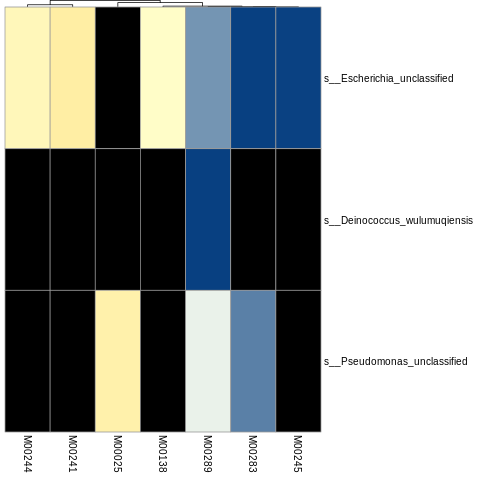

In [35]:
%%R
# Define colors
color_palette_blues <- colorRampPalette(c("#f7fcf0", "#084081"))
color_palette_reds <- colorRampPalette(brewer.pal(9, "YlOrRd"))
# To color relative abundances with zero values in white
breaks_below1 <- seq(0,1, length.out=100) # below 1% in blue scale
breaks_above1 <- seq(1.05,100, length.out=100) # above 1%, colored from orange to red
color_breaks <- c(-0.1,breaks_below1,breaks_above1)
color_colors <- c("black",rev(color_palette_blues(length(breaks_below1))), 
                  color_palette_reds(length(breaks_above1)-1))

# Define legends for annotations
create_cont_gglegend <- function(name,values,limits=c(0,1),
                                 breaks=c(-0.1,0,0.2,0.4,0.6,0.8),
                                 colors=c("black","red"),position="bottom"){
    dummy_plot <- ggplot() +
    geom_tile(aes(x='1', y=values, fill=values)) + 
    scale_fill_gradientn(name=name,
                         values=rescale(values, to=c(0,1)),
                         limits=limits,
                         breaks=breaks,
                         colors=colors
                         ) + 
    theme_void() + 
    theme(legend.title=element_text(size=11,face='bold'), 
          legend.text=element_text(size=11))
    if(position=="bottom"){
        dummy_plot <- dummy_plot +
        theme(legend.position=position) +
        guides(fill=guide_colourbar(title.position="top",barwidth=10))

    }
    cowplot::get_legend(dummy_plot)
}

colorbar_blv1 <- create_cont_gglegend(name="Abundance (%)",
                                      values=breaks_below1,
                                      breaks=c(-0.1,0,0.2,0.4,0.6,0.8,1),
                                      limits=c(0,1),
                                      colors=c("black",rev(color_palette_blues(length(breaks_below1))))
                                     )
colorbar_abv0 <- create_cont_gglegend(name="Abundance (%)",
                                      values=seq(1.05,100, length.out=100),
                                      breaks=c(1,20,40,60,80,100),
                                      limits=c(1,100),
                                      colors=color_palette_reds(length(breaks_above1)-1))

wms_samples_w_mock_contaminants_plot <- pheatmap(metaphlan_all_spp_abund_table[sub('^', 's__', 
                                                                                   wms_mock_contaminants),
                                                                               wms_samples_w_mock_contaminants],
                                                 color=color_colors,
                                                 breaks=color_breaks, 
                                                 treeheight_row=0,
                                                 treeheight_col=2,
                                                 legend=FALSE)

The mock community has even abundances (5%) of 20 species. Lets check the relative abundances obtained by MetaPhlAn2:

In [36]:
%%R
wms_mock_community_sp_ra
cat("Summary statistics of relative abundance of species in mock community: \n")
summary(wms_mock_community_sp_ra[c(sub("^", "s__", atcc_mock_detected),
                                   c("s__Propionibacterium_acnes","s__Bacillus_cereus_thuringiensis")),])

Summary statistics of relative abundance of species in mock community: 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.003   3.302   5.392   4.914   6.268   8.108 


Lets plot the observed compared to the expected relative abundances of the mock community:

In [37]:
%%R
atcc_mock_expected_ra <- rep(5,20)
atcc_mock_community_spp_renamed <- sub('^','s__',sub(' ','_',atcc_mock_community$species))
rename_mapping <- list("s__Bacillus_cereus_thuringiensis"="s__Bacillus_cereus",
                       "s__Propionibacterium_acnes"="s__Cutibacterium_acnes")
indices_in_mapping <- match(atcc_mock_community_spp_renamed,rename_mapping)
names_changed <- names(rename_mapping)[indices_in_mapping]
names_changed_ix <- which(!is.na(names_changed))
atcc_mock_community_spp_renamed[names_changed_ix] <- names_changed[names_changed_ix]
atcc_mock_community_spp_renamed

 [1] "s__Acinetobacter_baumannii"       "s__Actinomyces_odontolyticus"    
 [3] "s__Bacillus_cereus_thuringiensis" "s__Bacteroides_vulgatus"         
 [5] "s__Bifidobacterium_adolescentis"  "s__Clostridium_beijerinckii"     
 [7] "s__Propionibacterium_acnes"       "s__Deinococcus_radiodurans"      
 [9] "s__Enterococcus_faecalis"         "s__Escherichia_coli"             
[11] "s__Helicobacter_pylori"           "s__Lactobacillus_gasseri"        
[13] "s__Neisseria_meningitidis"        "s__Porphyromonas_gingivalis"     
[15] "s__Pseudomonas_aeruginosa"        "s__Rhodobacter_sphaeroides"      
[17] "s__Staphylococcus_aureus"         "s__Staphylococcus_epidermidis"   
[19] "s__Streptococcus_agalactiae"      "s__Streptococcus_mutans"         


In [38]:
%%R
set.seed(1234)
mock_data_toplot <- data.frame("Species"=rownames(wms_mock_community_sp_ra), 
                               "Abundance"=wms_mock_community_sp_ra[,1])
mock_data_toplot$Status <- "Observed"
#colnames(mock_data_toplot) <- c("Species","Abundance")
mock_data_toplot <- rbind(mock_data_toplot,
                          data.frame("Species"=atcc_mock_community_spp_renamed, 
                                     "Abundance"=atcc_mock_expected_ra,
                                     "Status"="Expected")
                         )
spp_colors <- colorRampPalette(brewer.pal(12,"Paired"))(length(unique(mock_data_toplot$Species)))
spp_colors <- spp_colors[shuffle(length(spp_colors))]
mock_data_plot <- ggplot(mock_data_toplot, aes(fill=Species, y=Abundance, x=Status)) + 
                    geom_bar(position="stack", stat="identity") +
                    scale_fill_manual(values = spp_colors)  + 
                    xlab("ATCC MSA-1002") + ylab("Abundance (%)") + 
                    theme_minimal()
mock_data_plot

[1] 11.805556  5.555556


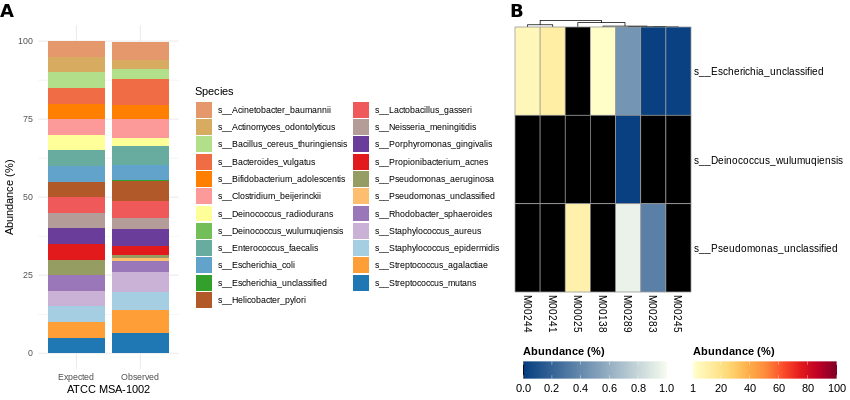

In [39]:
%%R -w 850 -h 400
print(par("din"))
# Save plots
heatmap_layout <- rbind(c(1,1,1,2,2),
                        c(3,3,3,4,4),
                        c(3,3,3,5,5))
wms_mock_community_panel <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                    textGrob("B",just="left", x=unit(0, "npc"), 
                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                    mock_data_plot, wms_samples_w_mock_contaminants_plot[[4]],
                                                    #Legends
                                                    cbind(colorbar_blv1, colorbar_abv0, size="last")
                                                   ),
                                         layout_matrix=heatmap_layout,
                                         nrow=3, heights=c(0.05,0.8,0.15), 
                                         widths=c(0.2,0.2,0.2,0.2,0.2))

# Saving panel
wms_mock_community_panel_file <- "./reports/figures/WMS-S_mock_community_panel.pdf"
ggsave(wms_mock_community_panel_file, wms_mock_community_panel, width=11.81, height=5.556, device=cairo_pdf)

Finally we add the potential contaminant identified in the mock community to our previously created list of contaminants:

In [40]:
%%R
# Extend list of potential contamiant spp.
wms_contaminants_ids_file <- "./data/interim/wms_contaminants_decontam.tsv"
wms_contaminants_ids <- read.table(wms_contaminants_ids_file, sep='\t',header=TRUE, stringsAsFactors=FALSE)
wms_contaminants_ids <- rbind(wms_contaminants_ids, 
                              data.frame("sp_id"=sub('^', 's__', wms_mock_contaminants),
                                         "freq"=rep(NA,length(wms_mock_contaminants)),
                                         "prev"=rep(NA,length(wms_mock_contaminants)),
                                         "p.freq"=rep(NA,length(wms_mock_contaminants)),
                                         "p.prev"=rep(NA,length(wms_mock_contaminants)),
                                         "p"=rep(NA,length(wms_mock_contaminants)),
                                         "contaminant"=rep(NA,length(wms_mock_contaminants))))

# save the extended list of WMS contaminants
write.table(wms_contaminants_ids, wms_contaminants_ids_file, sep="\t", row.names=FALSE)

In [41]:
!cat "./data/interim/wms_contaminants_decontam.tsv"

"sp_id"	"freq"	"prev"	"p.freq"	"p.prev"	"p"	"contaminant"
"s__Rothia_unclassified"	0.118167480314961	14	0.778716126906013	0.164808398950131	NA	TRUE
"s__Propionibacterium_acnes"	0.173562834645669	7	0.859223752721754	0.00388451443569557	NA	TRUE
"s__Granulicatella_unclassified"	2.78759826771654	74	0.994822285830062	0.409150356205474	NA	TRUE
"s__Ralstonia_pickettii"	0.563035590551181	43	0.981887112184291	0.489364829396326	NA	TRUE
"s__Ralstonia_unclassified"	8.62116133858268	86	0.992817556523146	0.153490813648294	NA	TRUE
"s__Deinococcus_wulumuqiensis"	NA	NA	NA	NA	NA	NA
"s__Escherichia_unclassified"	NA	NA	NA	NA	NA	NA
"s__Pseudomonas_unclassified"	NA	NA	NA	NA	NA	NA
